# **Transformed Homogeneous 2D wave equation**:
# $ u_t = u_{xx} + u_{yy} \qquad 0 < x < 1, \quad 0 < y < 1, \quad 0 < t < 1, \quad u ≡ u(x,y)$

## Boundary conditions (Dirichlet):
* $ u(x, 0, t) = u(x, 1, t) = 0 \qquad 0 \leq x, \,t \leq 1$
* $ u(0, y, t) = u(1, y, t) = 0 \qquad 0 \leq y, \,t \leq 1$

## Initial condition:
* $ u(x, y, 0) = \sin(3\pi x)\sin(2\pi y) \qquad 0 \leq x, \,y \leq 1 $

## *ANALYTICAL SOLUTION*
## $ u(x, y, t) = e^{-13\pi^2t}\sin(3\pi x)\sin(2\pi y)  $




# Imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Helpers

In [67]:
def generate_random_numbers(N, dtype):
    return torch.rand(N, dtype=dtype)


class LoadDataset(Dataset):
  def __init__(self, X):
    self.X = X

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx]

## Data

In [68]:
class Data():
    def __init__(self, batch_size=64, device='cpu', dtype=torch.float32):
        super().__init__()
        self.h_x_b = 1e-3
        self.h_y_b = 1e-3
        self.h_t_0 = 1e-3
        self.batch_size = batch_size
        self.device = device
        self.dtype = dtype

    # *** Create collocation points ***
    def sample_domain(self, Nx_domain, Ny_domain, Nt_domain, is_val=False):
        shuffle = !is_val

        # Random Grid
        x_domain = generate_random_numbers(Nx_domain, self.dtype)
        y_domain = generate_random_numbers(Ny_domain, self.dtype)
        t_domain = generate_random_numbers(Nt_domain, self.dtype)
        XY_domain = torch.stack(torch.meshgrid(x_domain, y_domain, t_domain)).view(3, -1).permute(1, 0).requires_grad_(True).to(self.device)
        print(f"Shape(XY_domain) = {XY_domain.shape}")

        if is_val:
            return XY_domain

        dataset = LoadDataset(X=XY_domain)
        dataloader = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=shuffle)

        return dataloader

    # *** Boundary Conditions ***
    def sample_boundary(self):
        # Uniform boundary points
        x_b = torch.arange(0, 1+self.h_x_b, self.h_x_b)
        y_b = torch.arange(0, 1+self.h_y_b, self.h_y_b)
        t_b = torch.arange(0, 1+self.h_t_0, self.h_t_0)

        # Random boundary points
        # x_b = generate_random_numbers(Nx_b, self.dtype)
        # y_b = generate_random_numbers(Ny_b, self.dtype)

        bc1 = torch.stack(torch.meshgrid(x_b, y_b[0], t_b)).view(3, -1).permute(1, 0)     #.squeeze().permute(1, 2, 0)
        bc2 = torch.stack(torch.meshgrid(x_b, y_b[-1], t_b)).view(3, -1).permute(1, 0)     #.squeeze().permute(1, 2, 0)
        bc3 = torch.stack(torch.meshgrid(x_b[0], y_b, t_b)).view(3, -1).permute(1, 0)     #.squeeze().permute(1, 2, 0)
        bc4 = torch.stack(torch.meshgrid(x_b[-1], y_b, t_b)).view(3, -1).permute(1, 0)     #.squeeze().permute(1, 2, 0)

        XY_b = torch.cat([bc1, bc2, bc3, bc4]).to(self.device)
        print(f"shape(X_b) = {XY_b.shape}")

        u_b = torch.zeros((len(XY_b), 1), device=self.device)
        print(f"shape(u_b) = {u_b.shape}")

        return XY_b, u_b

    # *** Initial Conditions ***
    def sample_initial(self):
        # Uniform initial points
        x_0 = torch.arange(0, 1+self.h_x_b, self.h_x_b)
        y_0 = torch.arange(0, 1+self.h_y_b, self.h_y_b)
        t_0 = torch.zeros((1,))

        XY_0 = torch.stack(torch.meshgrid(x_0, y_0, t_0)).squeeze().permute(1, 2, 0).view(-1, 3).to(self.device)
        print(f"Shape(XY_0) = {XY_0.shape}")

        u_0 = torch.outer(torch.sin(3*math.pi*x_0), torch.sin(2*math.pi*y_0)).view(-1, 1).to(self.device)
        print(f"Shape(u_0) = {u_0.shape}")

        return XY_0, u_0

## Network

In [69]:
class MLP(nn.Module):
  def __init__(self,
               layers,
               activation=nn.Tanh(),
               weight_init=None,
               bias_init=None,
               device='cpu'):

    super().__init__()
    self.n_layers = len(layers) - 1
    self.layers = layers
    self.activation = activation
    self.weight_init = weight_init
    self.bias_init = bias_init

    dense_layers = [
        self.dense_layer(in_features=self.layers[i],
                         out_features=self.layers[i+1])
        for i in range(self.n_layers - 1)]
    dense_layers.append(nn.Linear(in_features=self.layers[-2],
                                  out_features=self.layers[-1]))

    self.mlp = nn.Sequential(*dense_layers).to(device)

  def dense_layer(self, in_features, out_features):
    dense_layer = nn.Sequential(
      nn.Linear(in_features=in_features,
                out_features=out_features),
    )

    if self.weight_init is not None:
        self.weight_init(dense_layer[0].weight)

    if self.bias_init is not None:
        self.bias_init(dense_layer[0].bias)

    dense_layer.add_module("activation", self.activation)
    return dense_layer

  def forward(self, x):
    return self.mlp(x)

## PINN

In [70]:
class PINN():
    def __init__(self,
                 Nx_train, Ny_train, Nt_train,
                 Nx_val, Ny_val, Nt_val,
                 layers, activation,
                 batch_size,
                 checkpoint_path,
                 device='cpu',
                 dtype=torch.float32):

        # Constants
        self.v = 16 * math.pi**2
        self.checkpoint_path = checkpoint_path
        self.device = device
        self.dtype = dtype

        # Some initializations
        self.epoch = 1

        # Create the data
        print("Creating the data...")
        self.data = Data(batch_size, device, dtype)
        self.train_dataloader = self.data.sample_domain(Nx_train, Ny_train, Nt_train)
        self.XY_b_train, self.u_b_train = self.data.sample_boundary()
        self.XY_0_train, self.u_0_train = self.data.sample_initial()
        self.XY_val = self.data.sample_domain(Nx_val, Ny_val, Nt_val, is_val=True)

        # Define the model
        self.model = MLP(layers=layers,
                         activation=activation,
                         weight_init=lambda m: nn.init.xavier_normal_(m.data, nn.init.calculate_gain('tanh')),
                         bias_init=lambda m: nn.init.zeros_(m.data),
                         device=device)

        # Set the optimizers
        self.adam = torch.optim.Adam(self.model.parameters())

        self.lbfgs = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50_000,
            max_eval = 50_000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        # Set the Loss function
        self.criterion = torch.nn.MSELoss()


    def calculate_u(self, XY):
        return self.model(XY)


    def grad(self, output, input):
        return torch.autograd.grad(
                    output, input,
                    grad_outputs=torch.ones_like(output),
                    retain_graph=True,
                    create_graph=True
                )[0]


    def calculate_pde_residual(self, XY):
        # Forward pass
        u_hat = self.calculate_u(XY)

        # Calculate 1st and 2nd derivatives
        du_dX = self.grad(u_hat, XY)
        du_dXX = self.grad(du_dX, XY)

        # Retrieve the partial gradients
        du_dt = du_dX[:, 2]
        du_dxx = du_dXX[:, 0]
        du_dyy = du_dXX[:, 1]

        return du_dt - du_dxx - du_dyy


    def calculate_train_pde_loss(self, X):
        # Calculate the in-domain loss
        pde_res = self.calculate_pde_residual(X)
        return self.criterion(pde_res, torch.zeros_like(pde_res, dtype=self.dtype, device=self.device))


    def calculate_bound_init_losses(self):
        # Calculate initial loss
        loss_i = self.criterion(self.calculate_u(self.XY_0_train), self.u_0_train)

        # Calculate the boundary loss
        loss_b = self.criterion(self.calculate_u(self.XY_b_train), self.u_b_train)

        return loss_i, loss_b


    def calculate_val_loss(self):
        pde_res = self.calculate_pde_residual(self.XY_val)
        val_loss = self.criterion(pde_res, torch.zeros_like(pde_res, dtype=self.dtype, device=self.device))
        return val_loss


    def train_step(self):
        loss_pde = 0
        loss_i, loss_b = self.calculate_bound_init_losses()
        loss_bi = loss_i + loss_b

        for X_batch in self.train_dataloader:
            batch_loss_pde = self.calculate_train_pde_loss(X_batch)
            batch_loss = batch_loss_pde + loss_bi
            loss_pde += batch_loss_pde.item()
            self.optimizer.zero_grad()
            batch_loss.backward(retain_graph=True)

        loss_pde /= len(self.train_dataloader)
        loss = (loss_pde + loss_bi).cpu().item()

        self.val_loss = self.calculate_val_loss().cpu().item()

        # print losses
        self.flag = 0
        self.checkpoint_and_print_losses(loss_i.cpu().item(),
                                         loss_b.cpu().item(),
                                         loss_pde,
                                         loss)

        # Update "epoch"
        self.epoch = self.epoch + 1

        return loss


    def train(self, N_epochs_adam, print_every):
        self.print_every = print_every

        # Set model in training mode
        self.model.train()

        # Start with the "Adam" optimizer
        self.optimizer = self.adam

        for i in range(N_epochs_adam):
            self.optimizer.step(self.train_step)

        # Switch to "LBFGS" optimizer
        self.optimizer = self.lbfgs
        self.optimizer.step(self.train_step)


    def checkpoint_and_print_losses(self, loss_i, loss_b, loss_pde, loss):
        if self.epoch == 1:
            self.best_val_loss = self.val_loss
            best_epoch = -1
            self.checkpoint()
            self.flag = 1
            print(f"Epoch: {self.epoch} |loss_i: {loss_i} | loss_b: {loss_b} | loss_pde: {loss_pde} | loss: {loss} | val_loss: {self.val_loss} - *Checkpoint*")
        else:
            if self.val_loss < self.best_val_loss:
                self.best_val_loss = self.val_loss
                best_epoch = self.epoch
                self.checkpoint()
                self.flag = 1
                if self.epoch % print_every == 0:
                    print(f"Epoch: {self.epoch} |loss_i: {loss_i} | loss_b: {loss_b} | loss_pde: {loss_pde} | loss: {loss} | val_loss: {self.val_loss} - *Checkpoint*")

        if (self.flag == 0) and (self.epoch % print_every == 0):
            print(f"Epoch: {self.epoch} |loss_i: {loss_i} | loss_b: {loss_b} | loss_pde: {loss_pde} | loss: {loss} | val_loss: {self.val_loss}")

    def checkpoint(self):
        torch.save({
            "optimizer": self.optimizer.state_dict(),
            "model": self.model.state_dict()
        }, self.checkpoint_path)

# MAIN

In [71]:
# Data
Nx_train = Ny_train = Nt_train = 50
Nx_val = Ny_val = Nt_val = 50

# Model
n_hidden_layers = 3
hidden_layer_size = 64
layers = [3] + n_hidden_layers * [hidden_layer_size] + [1]
activation = nn.Tanh()

# Others
batch_size = 2500
N_epochs_adam = 100
print_every = 1
checkpoint_path = "model.pth"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float32

# Create "PINN" object
pinn = PINN(Nx_train, Ny_train, Nt_train,
            Nx_val, Ny_val, Nt_val,
            layers, activation,
            batch_size,
            checkpoint_path,
            device=device,
            dtype=dtype)

Creating the data...
Shape(XY_domain) = torch.Size([125000, 3])
shape(X_b) = torch.Size([4008004, 3])
shape(u_b) = torch.Size([4008004, 1])
Shape(XY_0) = torch.Size([1002001, 3])
Shape(u_0) = torch.Size([1002001, 1])
Shape(XY_domain) = torch.Size([125000, 3])


In [83]:
pinn.XY_0_train

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0010, 0.0000],
        [0.0000, 0.0020, 0.0000],
        ...,
        [1.0000, 0.9980, 0.0000],
        [1.0000, 0.9990, 0.0000],
        [1.0000, 1.0000, 0.0000]], device='cuda:0')

In [82]:
pinn.u_0_train

tensor([[ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        ...,
        [ 2.9969e-10],
        [ 1.4985e-10],
        [-4.1700e-15]], device='cuda:0')

In [80]:
u0_2D = pinn.u_0_train.cpu().numpy().reshape(1001, 1001)

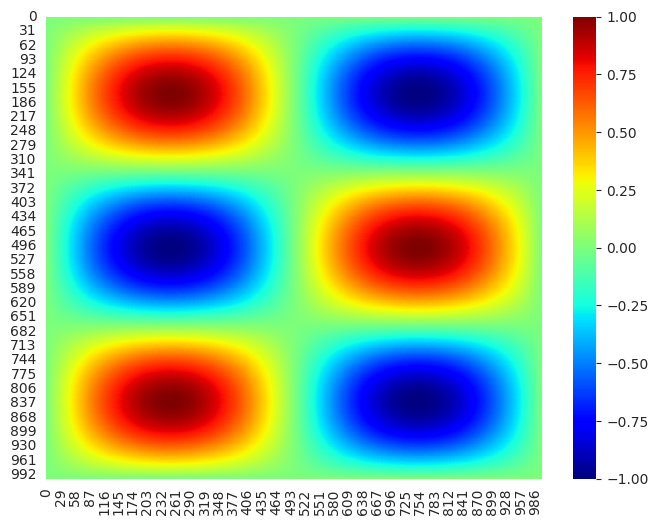

In [81]:
sns.set_style("white")
plt.figure(figsize=(8, 6))
sns.heatmap(u0_2D, cmap='jet')
plt.show()

In [72]:
# start = 234
# end = start + 50
# pinn.XY_val[start:end]

In [73]:
pinn.train(N_epochs_adam, print_every)

Epoch: 1 |loss_i: 0.2930593490600586 | loss_b: 0.03582633286714554 | loss_pde: 0.04981500677764416 | loss: 0.3787006735801697 | val_loss: 0.044408950954675674 - *Checkpoint*
Epoch: 2 |loss_i: 0.2680208683013916 | loss_b: 0.006986906286329031 | loss_pde: 0.02074839074164629 | loss: 0.29575616121292114 | val_loss: 0.023307031020522118 - *Checkpoint*
Epoch: 3 |loss_i: 0.26085397601127625 | loss_b: 0.004870259668678045 | loss_pde: 0.03762214161455631 | loss: 0.3033463954925537 | val_loss: 0.03668154776096344
Epoch: 4 |loss_i: 0.26124951243400574 | loss_b: 0.006300693843513727 | loss_pde: 0.018729657866060734 | loss: 0.2862798571586609 | val_loss: 0.017908558249473572 - *Checkpoint*
Epoch: 5 |loss_i: 0.26023659110069275 | loss_b: 0.005898185074329376 | loss_pde: 0.004791884804144502 | loss: 0.27092665433883667 | val_loss: 0.006629582028836012 - *Checkpoint*
Epoch: 6 |loss_i: 0.25617024302482605 | loss_b: 0.005350729450583458 | loss_pde: 0.012596031446009874 | loss: 0.27411702275276184 | val

KeyboardInterrupt: ignored

# Results and Plots

In [ ]:
# # Get test data
# print("Getting test data")
# XY_test = pinn.XY_test.detach()    #.numpy().cpu()
# x_test = pinn.x_test
# y_test = pinn.y_test

h = 1e-3
k = 1e-3
z = 1e-3

x_test = torch.arange(0, 1, h)
y_test = torch.arange(0, 1, k)
t_test = torch.arange(0, 1, z)

XY_test = torch.stack(torch.meshgrid(x_test, y_test, t_test)).view(-1, 3)
XY_test = XY_test.to("cpu")

# Load best model
print("Loading best model...")
checkpoint = torch.load(checkpoint_path)
pinn.model.load_state_dict(checkpoint['model'])
pinn.model.to("cpu")

# Inference
pinn.model.eval()
with torch.inference_mode():
    u_pred = pinn.model(XY_test)
    u_pred = u_pred.reshape(len(x_test), len(y_test), len(t_test)).numpy()

print(u_pred.shape)

Loading best model...


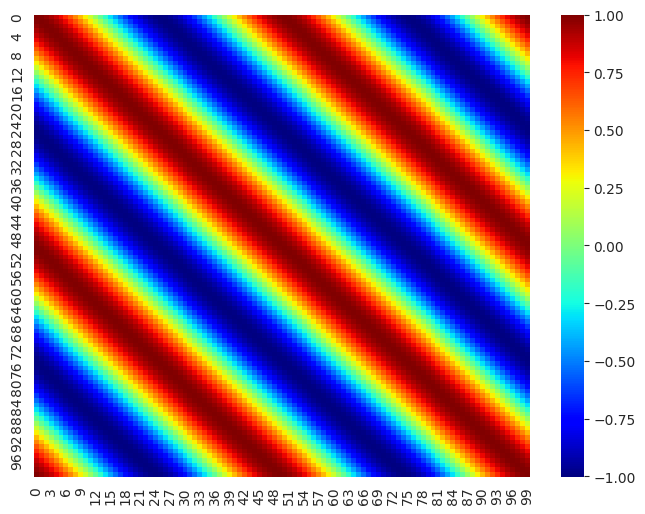

In [ ]:
sns.set_style("white")
plt.figure(figsize=(8, 6))
sns.heatmap(g_pred, cmap='jet')
plt.show()

In [ ]:
g_real = np.zeros((len(x_test), len(y_test)))
for i, xi in enumerate(x_test):
    for j, yj in enumerate(y_test):
        g_real[i, j] = np.cos(4*np.pi*(xi - yj))

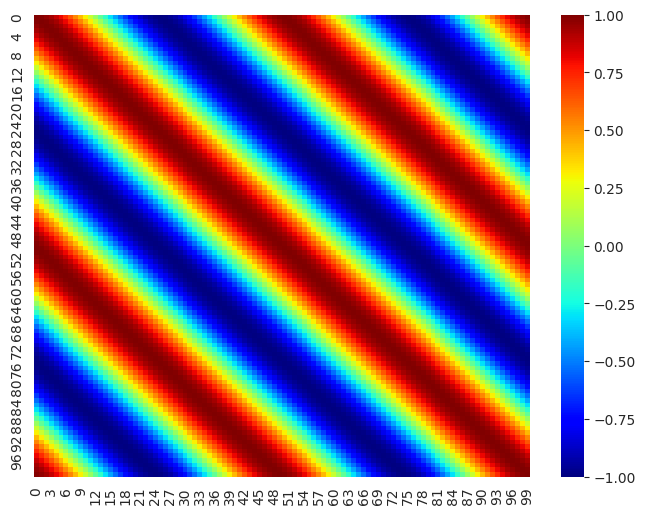

In [ ]:
sns.set_style("white")
plt.figure(figsize=(8, 6))
sns.heatmap(g_real, cmap='jet')
plt.show()

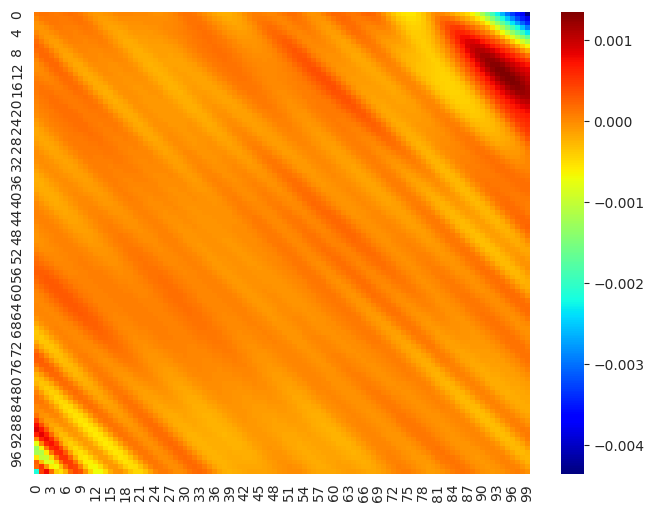

In [ ]:
sns.set_style("white")
plt.figure(figsize=(8, 6))
sns.heatmap(g_real-g_pred, cmap='jet')
plt.show()

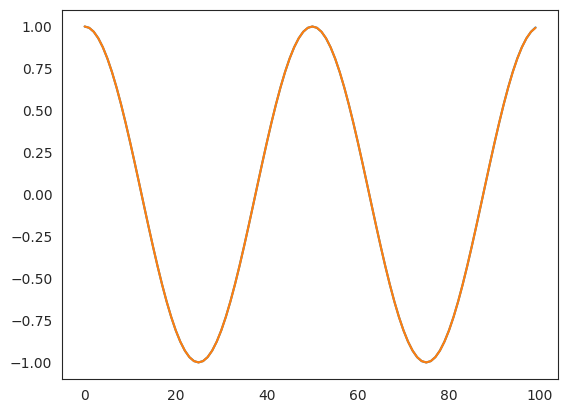

In [ ]:
plt.plot(g_pred[:, 0])
plt.plot(np.cos(4*np.pi*x_test))